# IMPORT LIBRARIES AND DATASET

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import random 

import os
import cv2
import gdown
from zipfile import ZipFile
from tensorflow.keras import layers
from tensorflow import keras
from tqdm import tqdm

import gc


0

In [ ]:
os.makedirs("celeba_gan")
#pip install gdown

In [8]:
#os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
url = "https://cseweb.ucsd.edu/~weijian/static/datasets/celeba/img_align_celeba.zip"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [9]:
folder = 'celeba_gan/img_align_celeba'
samples = os.listdir(folder)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8c7befaaf0>,
 <matplotlib.image.AxesImage at 0x7f8c7cc11f10>)

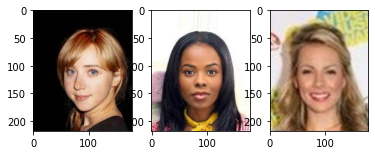

In [10]:
folder = 'celeba_gan/img_align_celeba'
samples = os.listdir(folder)
#print(samples)

img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(131), plt.imshow(img)
img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(132), plt.imshow(img)
img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(133), plt.imshow(img)

In [11]:
#size = 64 
# new size 178×218
x, y = [],[]
t= []
i=0
for sample in tqdm(samples):
    i=i +1
    if i > 2011:
        break
    img = cv2.cvtColor(cv2.imread(os.path.join(folder, sample)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (176, 216))
    if i > 2001:
        t.append(img)
    if i < 2001:  
        x.append(img)
  

  1%|          | 2011/202599 [00:01<02:13, 1503.66it/s]


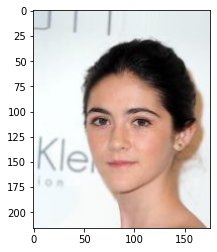

In [12]:
plt.imshow(x[0])

# Preprocessing data

In [13]:
X_train = np.array(x)/255

del x
gc.collect()

X_test = np.array(t)/255

del t
gc.collect()


0

In [27]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.044
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

In [28]:
noise_factor = 0.3

noise_dataset = []

for img in X_train:
  #noisy_image = img + noise_factor * np.random.randn(*img.shape)
  noisy_image = noisy("s&p" ,img)
  noisy_image = np.clip(noisy_image, 0., 1.)
  noise_dataset.append(noisy_image)

<ipython-input-27-e9596b5aeaf5>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-27-e9596b5aeaf5>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


In [36]:
noise_dataset = np.array(noise_dataset)
noise_dataset.shape

(2000, 216, 176, 3)

2688

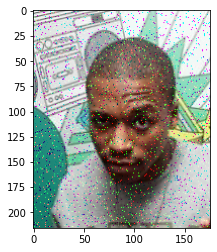

In [37]:
plt.imshow(noise_dataset[22], cmap="gray")
gc.collect()

In [38]:
noise_test_set = []
for img in X_test:
  #noisy_image = img + noise_factor * np.random.randn(*img.shape)
  noisy_image = noisy("s&p" ,img)
  noisy_image = np.clip(noisy_image, 0., 1.)
  noise_test_set.append(noisy_image)
  
noise_test_set = np.array(noise_test_set)
noise_test_set.shape

<ipython-input-27-e9596b5aeaf5>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-27-e9596b5aeaf5>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


(10, 216, 176, 3)

In [10]:
gc.collect()

2409

BUILD AND TRAIN AUTOENCODER DEEP LEARNING MODEL

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.”

In [39]:
autoencoder = tf.keras.models.Sequential()

#Encoder
autoencoder.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(216, 176, 3)))
autoencoder.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))

#Encoded image
autoencoder.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding="same"))

#Decoder
autoencoder.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, activation='sigmoid', padding="same"))


In [40]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 108, 88, 16)       448       
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 44, 8)         1160      
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 44, 8)         584       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 108, 88, 16)      1168      
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 216, 176, 3)      435       
 ranspose)                                                       
                                                                 
Total params: 3,795
Trainable params: 3,795
Non-traina

In [41]:
autoencoder.fit(noise_dataset.reshape(-1, 216, 176, 3),          
                X_train.reshape(-1, 216, 176, 3), 
                epochs=10, 
                batch_size=200, 
                validation_data=(noise_test_set.reshape(-1, 216, 176, 3), X_test.reshape(-1, 216, 176, 3)))


Epoch 1/10
10/10 [==============================] - 11s 191ms/step - loss: 0.6876 - val_loss: 0.6828
Epoch 2/10
10/10 [==============================] - 2s 156ms/step - loss: 0.6745 - val_loss: 0.6710
Epoch 3/10
10/10 [==============================] - 2s 152ms/step - loss: 0.6552 - val_loss: 0.6456
Epoch 4/10
10/10 [==============================] - 2s 151ms/step - loss: 0.6192 - val_loss: 0.6052
Epoch 5/10
10/10 [==============================] - 2s 151ms/step - loss: 0.5768 - val_loss: 0.5683
Epoch 6/10
10/10 [==============================] - 2s 152ms/step - loss: 0.5288 - val_loss: 0.5426
Epoch 7/10
10/10 [==============================] - 2s 151ms/step - loss: 0.5116 - val_loss: 0.5389
Epoch 8/10
10/10 [==============================] - 2s 156ms/step - loss: 0.5043 - val_loss: 0.5333
Epoch 9/10
10/10 [==============================] - 2s 167ms/step - loss: 0.4998 - val_loss: 0.5307
Epoch 10/10
10/10 [==============================] - 2s 175ms/step - loss: 0.4967 - val_loss: 0.528

 EVALUATE TRAINED MODEL PERFORMANCE

In [42]:
evaluation = autoencoder.evaluate(noise_test_set.reshape(-1, 216, 176, 3), X_test.reshape(-1, 216, 176, 3))
print('Test Accuracy : {:.3f}'.format(evaluation))

1/1 [==============================] - 0s 25ms/step - loss: 0.5288
Test Accuracy : 0.529


In [43]:
predicted = autoencoder.predict(noise_test_set[:10].reshape(-1, 216, 176, 3))

1/1 [==============================] - 0s 92ms/step


In [44]:
blured_test_set = []
for img in noise_test_set:
  blured_image = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
  blured_test_set.append(blured_image)
  
blured_test_set = np.array(blured_test_set)
blured_test_set.shape

(10, 216, 176, 3)

In [45]:
predicted.shape

(10, 216, 176, 3)

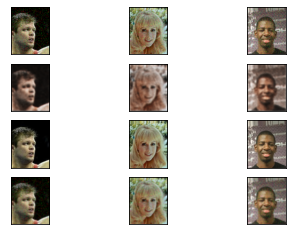

In [46]:
fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True)
for images, row in zip([noise_test_set[:3], predicted, X_test, blured_test_set], axes):
    for img, ax in zip(images, row):
        #ax.imshow(img.reshape((216, 64)))
        ax.imshow(img.reshape((216, 176, 3)))        
        #ax.imshow(img.reshape((64, 64)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

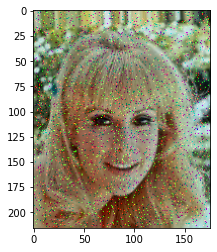

In [51]:
plt.imshow(noise_test_set[1])

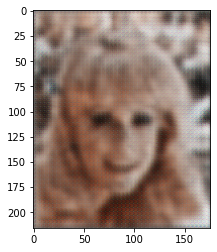

In [47]:
plt.imshow(predicted[1])

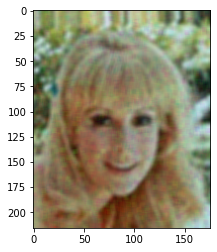

In [48]:
plt.imshow(blured_test_set[1])

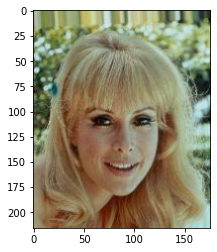

In [49]:
plt.imshow(X_test[1])

As the result, it makes sense to use convolutional neural networks as encoders and decoders. However, the convolutional autoencoders generate a very blured version of the original image.

Compared to the Gaussian bluring, the results with convolutional networks are in my opinion better in case of heavy noice. 

In case of not buch noice on the images, it is most likely better to use Gaussian bluring.

Tested noise type: salt&pepper, poisson, speckle